<a href="https://colab.research.google.com/github/AlexCuozzo/AttractorDynamics/blob/master/Dynamics/numeric/network_simulation/sparse_mnist_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [ ]:
input_dim = 784
batch_size = 28
encoding_dim = 28

In [ ]:
#setup MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data",transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root="./data",train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class ConvNetEncoder(nn.Module):
    def __init__(self):
        super(ConvNetEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=3)
        self.conv2 = nn.Conv2d(100, 2000, kernel_size=3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = torch.sigmoid(x)
        # x = self.conv3(x)
        # x = F.max_pool2d(x, kernel_size=2)
        # x = F.relu(x)
        return x

In [ ]:
class LinearDecoder(nn.Module):
    def __init__(self):
      super(LinearDecoder, self).__init__()
      self.fc = nn.Linear(50000, 784)

    def forward(self, x):
      x = self.fc(x)
      return torch.sigmoid(x)

In [ ]:
class ConvNetAutoencoder(nn.Module):
    def __init__(self):
      super(ConvNetAutoencoder,self).__init__()
      self.encoder = ConvNetEncoder()
      self.decoder = LinearDecoder()
    
    def forward(self, x):
      encoded = self.encoder(x).view(-1, 50000)
      decoded = self.decoder(encoded).view(-1, 1, 28, 28)
      return encoded, decoded

In [ ]:
def train_model(model, train_loader, num_epochs=10, lr=0.001, loss_func = None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def cross_entropy_loss(encoded, decoded, input):
        return nn.BCELoss()(decoded, input)
    loss_function = cross_entropy_loss if loss_func is None else loss_func
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model = model.to(device)
    model.train()
    # train the model to convergence
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.reshape(-1, 1, 28, 28).to(device)
            # run model and calculate loss
            encoded, decoded = model.forward(images)
            loss = loss_function(encoded, decoded, images)
            # calculate gradients and step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if not (i + 1) % 100:
                print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
        print("EPOCH {} COMPLETE".format(epoch + 1))

In [ ]:
model = ConvNetAutoencoder()

In [ ]:
train_model(model, train_loader, lr=1e-4)

Epoch [1/10], Step[100/2143], Loss: 0.1412
Epoch [1/10], Step[200/2143], Loss: 0.1178
Epoch [1/10], Step[300/2143], Loss: 0.0999
Epoch [1/10], Step[400/2143], Loss: 0.0857
Epoch [1/10], Step[500/2143], Loss: 0.0803
Epoch [1/10], Step[600/2143], Loss: 0.0888
Epoch [1/10], Step[700/2143], Loss: 0.0716
Epoch [1/10], Step[800/2143], Loss: 0.0783
Epoch [1/10], Step[900/2143], Loss: 0.0826
Epoch [1/10], Step[1000/2143], Loss: 0.0858
Epoch [1/10], Step[1100/2143], Loss: 0.0746
Epoch [1/10], Step[1200/2143], Loss: 0.0798
Epoch [1/10], Step[1300/2143], Loss: 0.0752
Epoch [1/10], Step[1400/2143], Loss: 0.0813
Epoch [1/10], Step[1500/2143], Loss: 0.0786
Epoch [1/10], Step[1600/2143], Loss: 0.0794
Epoch [1/10], Step[1700/2143], Loss: 0.0672
Epoch [1/10], Step[1800/2143], Loss: 0.0689
Epoch [1/10], Step[1900/2143], Loss: 0.0767
Epoch [1/10], Step[2000/2143], Loss: 0.0728
Epoch [1/10], Step[2100/2143], Loss: 0.0718
EPOCH 1 COMPLETE
Epoch [2/10], Step[100/2143], Loss: 0.0733
Epoch [2/10], Step[200/21

KeyboardInterrupt: ignored

In [ ]:
test_images = train_dataset.data[:10].type(torch.float).to(device)

In [ ]:
encoded, decoded = model(test_images.view(-1, 1, 28, 28))

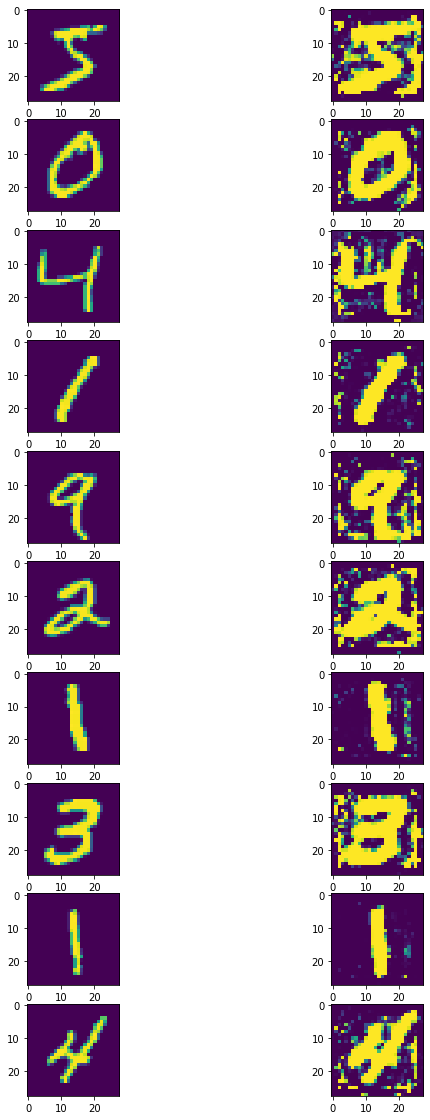

In [ ]:
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (im, de) in enumerate(zip(test_images, decoded)):
    axs[i, 0].imshow(im.detach().cpu().view(28, 28))
    axs[i, 1].imshow(de.detach().cpu().view(28, 28))
plt.show()

In [ ]:
sparse_model = ConvNetAutoencoder()
def sparse_loss_func(encoded, decoded, input, alpha=1e-5):
    sparsity_loss = torch.sum(torch.abs(encoded))
    bce_loss = nn.BCELoss()(decoded, input)
    return alpha*sparsity_loss + bce_loss

In [ ]:
train_model(sparse_model, train_loader, loss_func=sparse_loss_func, lr=1e-5)

Epoch [1/10], Step[100/2143], Loss: 0.9035
Epoch [1/10], Step[200/2143], Loss: 0.7359
Epoch [1/10], Step[300/2143], Loss: 0.6592
Epoch [1/10], Step[400/2143], Loss: 0.5803
Epoch [1/10], Step[500/2143], Loss: 0.5364
Epoch [1/10], Step[600/2143], Loss: 0.5055
Epoch [1/10], Step[700/2143], Loss: 0.4742
Epoch [1/10], Step[800/2143], Loss: 0.4540
Epoch [1/10], Step[900/2143], Loss: 0.4474
Epoch [1/10], Step[1000/2143], Loss: 0.4130
Epoch [1/10], Step[1100/2143], Loss: 0.3850
Epoch [1/10], Step[1200/2143], Loss: 0.3991
Epoch [1/10], Step[1300/2143], Loss: 0.4157
Epoch [1/10], Step[1400/2143], Loss: 0.3942
Epoch [1/10], Step[1500/2143], Loss: 0.4032
Epoch [1/10], Step[1600/2143], Loss: 0.3806
Epoch [1/10], Step[1700/2143], Loss: 0.3928
Epoch [1/10], Step[1800/2143], Loss: 0.3543
Epoch [1/10], Step[1900/2143], Loss: 0.3816
Epoch [1/10], Step[2000/2143], Loss: 0.3566
Epoch [1/10], Step[2100/2143], Loss: 0.3500
EPOCH 1 COMPLETE
Epoch [2/10], Step[100/2143], Loss: 0.3454
Epoch [2/10], Step[200/21

KeyboardInterrupt: ignored

In [ ]:
sparse_encoded, sparse_decoded = sparse_model(test_images.view(-1, 1, 28, 28))

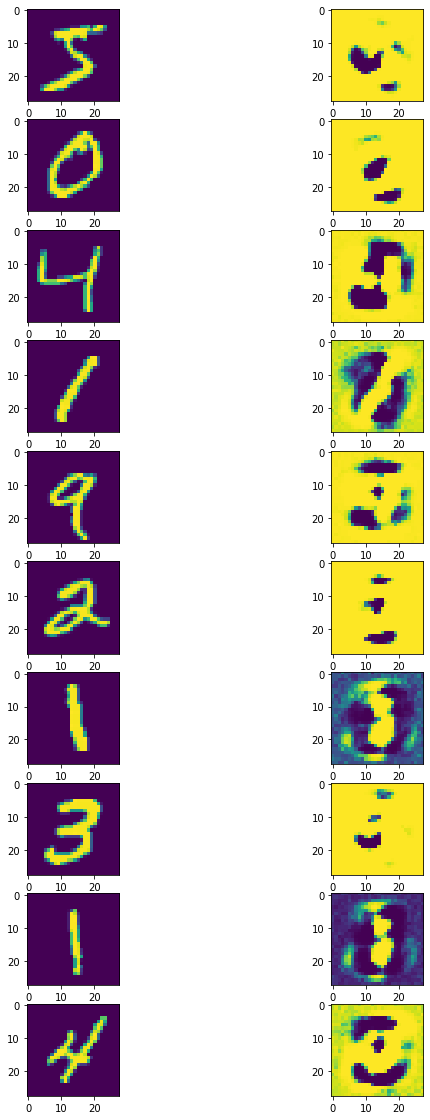

In [ ]:
fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i, (im, de) in enumerate(zip(test_images, sparse_decoded)):
    axs[i, 0].imshow(im.detach().cpu().view(28, 28))
    axs[i, 1].imshow(de.detach().cpu().view(28, 28))
plt.show()

In [ ]:
pattern_images = train_dataset.data[:30].type(torch.float).to(device).view(-1, 1, 28, 28)
labels = train_dataset.train_labels[:30]
conv_autoencoder_encodings, _ = model(pattern_images)
sparse_conv_autoencoder_encodings, _ = sparse_model(pattern_images)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [ ]:
data = [conv_autoencoder_encodings.cpu(), sparse_conv_autoencoder_encodings.cpu(), labels]

In [ ]:
torch.save(conv_autoencoder_encodings.numpy().cpu(), "patterns_conv")
torch.save(sparse_conv_autoencoder_encodings.cpu(), "patterns_conv_sparse")
torch.save(labels, "patterns_labels")

TypeError: ignored

In [ ]:
import pickle

In [ ]:
with open("data.pkl", "wb") as f:
  data = [conv_autoencoder_encodings.detach().cpu().numpy(), sparse_conv_autoencoder_encodings.detach().cpu().numpy(), labels.detach().cpu().numpy()]
  pickle.dump(data, f)

In [ ]:
with open("pattern_data.pkl", "rb") as f:
  data = pickle.load(f)

In [ ]:
data[1].shape

(30, 50000)

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.hist(data[1])

KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt
